In [152]:
import numpy as np
import pandas as pd
import networkx as nx
import nltk
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [110]:
# Load data
comic_graph = nx.read_gpickle('../Data/full_graph_directed.pickle')

con_comp = sorted(nx.weakly_connected_components(comic_graph), key = len, reverse = True)
comic_graph_GCC = comic_graph.subgraph(con_comp[0]).copy()

# Part 1: Visualization and Statistics of the Network

## Part 1a: Basic Statistics of the Network

**What is the number of nodes in the network?**

In [154]:
N = len(comic_graph_GCC.nodes())
print(N)

2593


**What is the number of links?**

In [155]:
L = len(comic_graph_GCC.edges())
print(L)

24975


**What is the number of links connecting Marvel and DC? Explain what those links mean?**

In [56]:
marvel_nodes = [superhero for superhero, univserse in nx.get_node_attributes(comic_graph_GCC, 'Universe').items() if univserse == 'Marvel']
dc_nodes = [superhero for superhero, univserse in nx.get_node_attributes(comic_graph_GCC, 'Universe').items() if univserse == 'DC']


In [82]:
num_of_links_between_marvel_dc = []
num_of_links_between_dc_marvel = []

for marvel_node, dc_node in zip(marvel_nodes, dc_nodes):
    edges_from_marvel_node = list(dict(comic_graph_GCC[marvel_node]).keys())
    
    # calculate the number of links between the marvel node and the DC nodes.
    num_of_links_from_marvel_node_to_dc_nodes = sum([edge in dc_nodes for edge in edges_from_marvel_node])
    num_of_links_between_marvel_dc.append(num_of_links_from_marvel_node_to_dc_nodes)
    
    
    edges_from_dc_node = list(dict(comic_graph_GCC[dc_node]).keys())
    num_of_links_from_dc_node_to_marvel_nodes = sum([edge in marvel_nodes for edge in edges_from_dc_node])
    num_of_links_between_dc_marvel.append(num_of_links_from_dc_node_to_marvel_nodes)
    

print(sum(num_of_links_between_marvel_dc))
print(sum(num_of_links_between_dc_marvel))

338
468


**Who are top 5 most connected characters? (Report results for in-degrees and out-degrees).**

In [83]:
dict(sorted(dict(comic_graph_GCC.in_degree).items(), key = itemgetter(1), reverse = True)[:5])

{'Superman': 589,
 'Batman': 574,
 'Spider-Man': 479,
 'Captain America': 430,
 'Iron Man': 355}

In [84]:
dict(sorted(dict(comic_graph_GCC.out_degree).items(), key = itemgetter(1), reverse = True)[:5])

{'Barracuda (II)': 67,
 'Belthera, Queen': 59,
 'Deathstroke': 59,
 'Butcher': 54,
 'Venom': 52}

**Plot the in and out-degree distributions.**

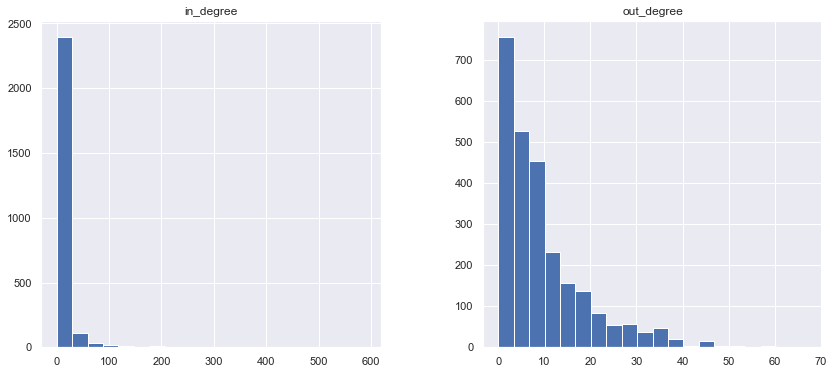

In [167]:
degree_distribution = pd.DataFrame({
    'in_degree' : np.array(list(dict(comic_graph_GCC.in_degree).values())),
    'out_degree' : np.array(list(dict(comic_graph_GCC.out_degree).values()))
})
hist = degree_distribution.hist(bins=20, figsize=(14,6))

Explain what you observe?
Explain why the in-degree distribution is different from the out-degree distribution?

**Compare the degree distribution to a random network with the same number of nodes and probability of connection $p$.**

In [168]:
degree_distribution.mean()

in_degree     9.631701
out_degree    9.631701
dtype: float64

From [1, eq. (3.3)] it is know that $\langle k \rangle = p (N-1)$. In this equation $p$ can be isolated and results in the following expression:
$$p = \frac{\langle k \rangle}{N-1}.$$
As the mean, which is $\langle k \rangle$, in the Poisson distribution is equal $\lambda$ the values can easily be inserted and it this specific case it yields:
$$p = \frac{9.631701}{2593} = 0.003714500964.$$

In [169]:
rg = nx.erdos_renyi_graph(n = N, p = 0.003714500964, seed=123, directed=True)

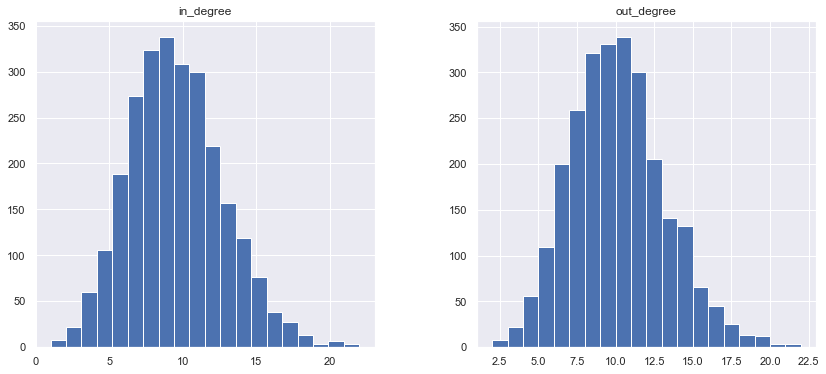

In [170]:
rg_degree_distribution = pd.DataFrame({
    'in_degree' : np.array(list(dict(rg.in_degree).values())),
    'out_degree' : np.array(list(dict(rg.out_degree).values()))
})
hist = rg_degree_distribution.hist(bins=20, figsize=(14,6))

Something about hubs here...
Poison distribution ... lalala


## Part 1b: Visualization of the Network


**Create a nice visualization of the total network with the following properties**
  - Color nodes according to universe
  - Scale node-size according to degree
  - Whatever else you feel like.
  - If you can get it to work, get node positions based on the Force Atlas 2 algorithm